In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import requests
from matplotlib import pyplot as plt

In [36]:
# Download & show the data
#Workaround to handle issue https://github.com/pydata/pandas-datareader/issues/868
USER_AGENT = {
    'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'
                ' Chrome/91.0.4472.124 Safari/537.36')
    }
sesh = requests.Session()
sesh.headers.update(USER_AGENT)


start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)

btc_df = web.DataReader("BTC-USD", 'yahoo', start, end,  session=sesh)
btc_df

High           Low          Open         Close  \
Date                                                                 
2014-09-17    468.174011    452.421997    465.864014    457.334015   
2014-09-18    456.859985    413.104004    456.859985    424.440002   
2014-09-19    427.834991    384.532013    424.102997    394.795990   
2014-09-20    423.295990    389.882996    394.673004    408.903992   
2014-09-21    412.425995    393.181000    408.084991    398.821014   
...                  ...           ...           ...           ...   
2020-12-28  27389.111328  26207.640625  26280.822266  27084.808594   
2020-12-29  27370.720703  25987.298828  27081.810547  27362.437500   
2020-12-30  28937.740234  27360.089844  27360.089844  28840.953125   
2020-12-31  29244.876953  28201.992188  28841.574219  29001.720703   
2021-01-01  29600.626953  28803.585938  28994.009766  29374.152344   

                 Volume     Adj Close  
Date                                   
2014-09-17     21056800    457.334015  
2014-09-18     34483200    424.440002  
2014-09-19     37919700    394.795990  
2014-09-20     36863600    408.903992  
2014-09-21     26580100    398.821014  
...                 ...           ...  
2020-12-28  49056742893  27084.808594  
2020-12-29  45265946774  27362.437500  
2020-12-30  51287442704  28840.953125  
2020-12-31  46754964848  29001.720703  
2021-01-01  40730301359  29374.152344  

[2299 rows x 6 columns]

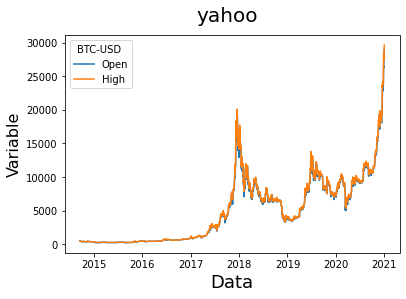

In [38]:
# Plot some of the variables
fig, ax = plt.subplots()
ax.plot(btc_df['Open'], label='Open') 
ax.plot(btc_df['High'], label='High') 
fig.suptitle('yahoo', fontsize=20)
plt.xlabel('Data', fontsize=18)
plt.ylabel('Variable', fontsize=16)
ax.legend(title='BTC-USD ')
resolution_value = 1200
# save the plot
#plt.savefig('BTC-USD-yahoo-variables.png', format="png", dpi=resolution_value)


In [3]:
# Relative difference btw. Open & Close value
btc_df['delta_pct'] = (btc_df['Close'] - btc_df['Open'])/btc_df['Open']

In [33]:
# Rolling window function
def rolling_window(a, window):
    """
        Takes np.array 'a' and size 'window' as parameters
        Outputs an np.array with all the ordered sequences of values of 'a' of size 'window'
        e.g. Input: ( np.array([1, 2, 3, 4, 5, 6]), 4 )
             Output: 
             
                     array([[1, 2, 3, 4],
                           [2, 3, 4, 5],
                           [3, 4, 5, 6]])
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [34]:
# Column 'going_up' w/ ones if 'delta_pct' is > 0
if not 'going_up' in btc_df.columns: btc_df['going_up'] = btc_df['delta_pct'].apply(lambda d: 1 if d>0.00001 else 0).to_numpy()

In [20]:
print(type(btc_df['going_up']))

<class 'pandas.core.series.Series'>


In [21]:
# convert to numpy
element=btc_df['going_up'].to_numpy()
print(type(element))

<class 'numpy.ndarray'>


In [23]:
# How many days do we consider
WINDOW_SIZE=15

In [70]:
# Define the training set
training_data = rolling_window(element, WINDOW_SIZE)
training_data
# save the data 
pd.DataFrame(training_data).to_csv("training_data.csv", index=False)

In [56]:
# Take the las element in training data
Y = training_data[:,-1]
Y

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
# The rest of the vector except the last column (which is Y)
X=training_data[:,:-1]
X

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1]])

In [66]:
# sklearn & mlflow libs
from sklearn.linear_model import LogisticRegression # Logistic regression model 
from sklearn.model_selection import train_test_split
import mlflow

In [67]:
# Split the dataset consider 25% samples as test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4284, stratify=Y)
X_train

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 1]])

In [68]:
# Start autolog
mlflow.sklearn.autolog()

In [69]:
lr = LogisticRegression()
lr.fit(X,Y)
score = lr.score(X, Y)
print("Score: %s" % score)
mlflow.log_metric("score", score)
mlflow.sklearn.log_model(lr, "model")
print("Model saved in run %s" % mlflow.active_run().info.run_uuid)


2022/04/01 09:46:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/users/renex/workspace/devTools/anaconda3/envs/mlflow/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/04/01 09:46:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/users/renex/workspace/devTools/anaconda3/envs/mlflow/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`."
2022/04/01 09:46:35 WARNING 

Score: 0.5536105032822757
Model saved in run 4972147d864f4dc393a8876540ad8dc8
